# Statistics Seperated by scaffold present v. no scaffold present

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
%matplotlib inline

In [2]:
def my_float(s):
    if s == 'None': return float('inf')
    return float(s)

data = {}
last_protein = None
with open('../../stats.csv') as fp:
    print fp.readline()
    for line in fp:
        (protein, struct, ligand1, ligand2,
         rank1, rank2, rmsd1, rmsd2, gscore1, gscore2,
         sb2, mcss, hbond, pipi, contact) = line.strip().split('\t')
        if protein != last_protein: print protein
        last_protein = protein
        (rmsd1, rmsd2, gscore1, gscore2,
         sb2, mcss, hbond, pipi, contact) = map(my_float, [rmsd1, rmsd2, gscore1, gscore2,
                                                           sb2, mcss, hbond, pipi, contact])
        rank1, rank2 = int(rank1), int(rank2)
        if rank1 > 10 or rank2 > 10: continue
        if protein not in data: data[protein] = {}
        if (ligand1, ligand2) not in data[protein]: data[protein][(ligand1, ligand2)] = {}
        data[protein][(ligand1, ligand2)][rank1, rank2] = {'rmsd1':rmsd1,
                                                           'rmsd2':rmsd2,
                                                           'gscore1': gscore1,
                                                           'gscore2': gscore2,
                                                           'sb2': sb2,
                                                           'mcss': mcss,
                                                           'hbond': hbond,
                                                           'pipi': pipi,
                                                           'contact': contact}

Protein	Struct	Ligand1	Ligand2	Rank1	Rank2	RMSD1	RMSD2	GSCORE1	GSCORE2	sb2	mcss	hbond	pipi	contact

O60885
GCR
BRAF
DTRANSP
P00749
SMO
P03951
AR
MEK1
5HT2B
P00760
CDK2
SIGMA1
JAK2
ERA
P18031
P00489
A2AR
PLK1
VITD
GLUT1
MGLUR5
STRANSP
B2AR
TRPV1
Q9Y233
P00734
MR
M3
Q16539
P00742
P56817
P07900
P24941
B1AR
CHK1


In [3]:
for prot, ligpairs in data.items():
    print prot, len(ligpairs)

P00489 190
5HT2B 1
PLK1 66
Q16539 171
MGLUR5 10
ERA 171
M3 1
P07900 190
GLUT1 3
P18031 190
P56817 190
O60885 136
MEK1 190
JAK2 190
P00742 190
DTRANSP 36
SIGMA1 1
P00734 190
P00760 190
B2AR 28
GCR 153
P24941 78
B1AR 66
VITD 190
A2AR 153
SMO 21
P03951 91
P00749 190
Q9Y233 190
CHK1 190
TRPV1 1
CDK2 190
AR 55
BRAF 171
MR 78
STRANSP 10


In [4]:
from sklearn.neighbors import KernelDensity

def reflect(x, y):
    x, y = np.array(x), np.array(y)
    center_x, center_y = x[(0<=x)*(x<1)], y[(0<=x)*(x<1)]
    left_x, left_y     = x[x < 0], y[x < 0]
    right_x, right_y   = x[x > 1], y[x > 1]
    center_y += left_y[::-1]
    center_y += right_y[::-1]
    return center_x, center_y

def plot(native, decoy):
    
    print sum(native == float('inf')), native.shape
    print sum(decoy == float('inf')), decoy.shape
    
    native = native[native != float('inf')]
    decoy = decoy[decoy != float('inf')]
    
    # histogram
    plt.hist([native, decoy], normed = True, label = ['native', 'decoy'])
    plt.legend()
    plt.show()
    
    # KDE
    x = np.linspace(-1, 2, 301)
    native_kernel = KernelDensity(bandwidth = 0.05).fit(native.reshape(-1, 1))
    decoy_kernel  = KernelDensity(bandwidth = 0.05).fit(decoy.reshape(-1, 1))
    native_kde = np.exp(native_kernel.score_samples(x.reshape(-1, 1)))
    decoy_kde = np.exp(decoy_kernel.score_samples(x.reshape(-1, 1)))

    # Reflected KDE
    center, native_center = reflect(x, native_kde)
    center, decoy_center = reflect(x, decoy_kde)
    plt.plot(center, native_center, label = 'native')
    plt.plot(center, decoy_center, label = 'decoy')
    plt.show()

    # Energy
    plt.plot(center, - np.log(native_center / decoy_center))
    plt.show()

# Top Pose Only

sb2
(1072,) (4161,)
799 (1072,)
2986 (4161,)


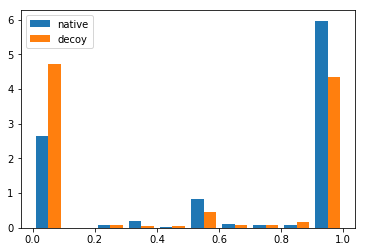

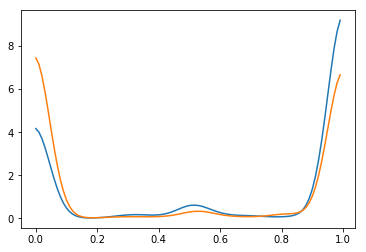

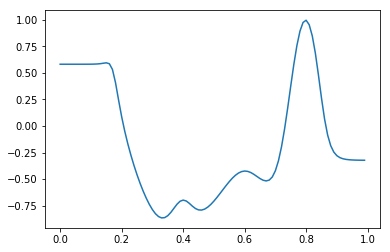

hbond
(1072,) (4161,)
9 (1072,)
40 (4161,)


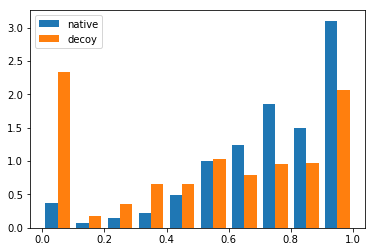

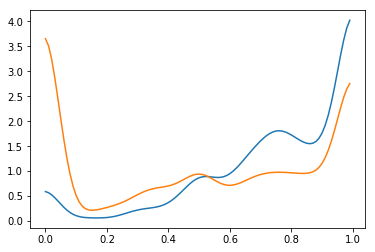

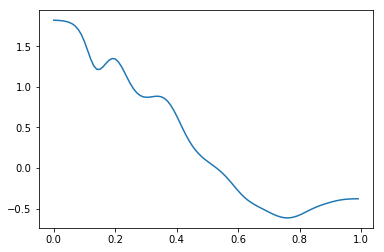

mcss
(1072,) (4161,)
914 (1072,)
3771 (4161,)


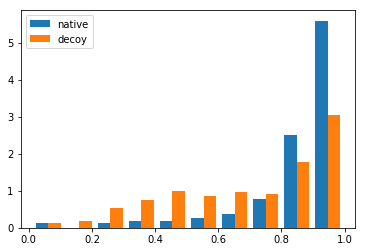

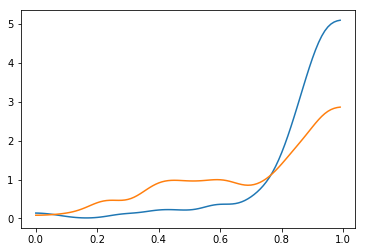

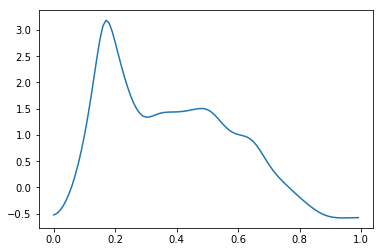

pipi
(1072,) (4161,)
325 (1072,)
735 (4161,)


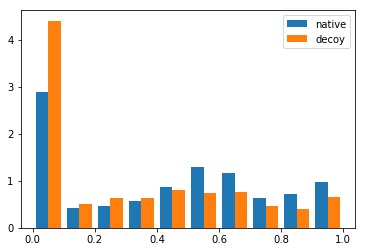

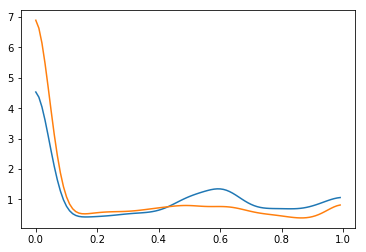

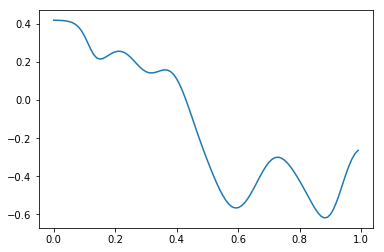

contact
(1072,) (4161,)
0 (1072,)
10 (4161,)


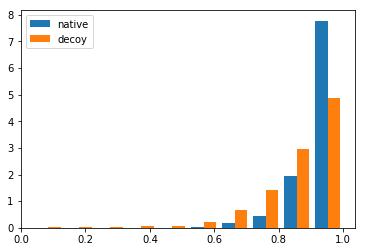

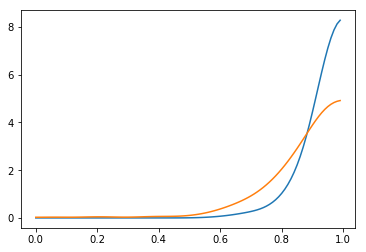

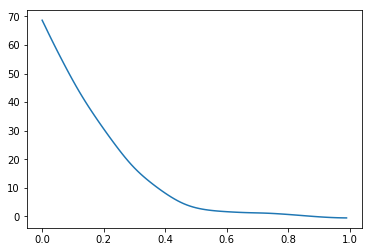

In [7]:
for interaction in ['sb2', 'hbond', 'mcss', 'pipi', 'contact']:
    native, decoy = [], []
    for protein, ligpairs in data.items():
        for (lig1, lig2), posepairs in ligpairs.items():
            for (rank1, rank2), fp in posepairs.items():
                if rank1 == rank2 == 0:
                    if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                        native += [fp[interaction]]
                    decoy += [fp[interaction]]
    native, decoy = np.array(native), np.array(decoy)
    print interaction
    print native.shape, decoy.shape
    plot(native, decoy)

sb2
(1514,) (2260,)
1030 (1514,)
1685 (2260,)


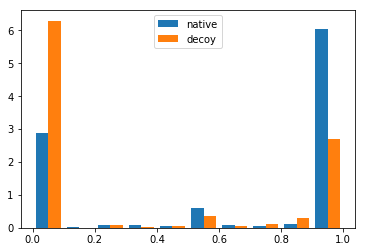

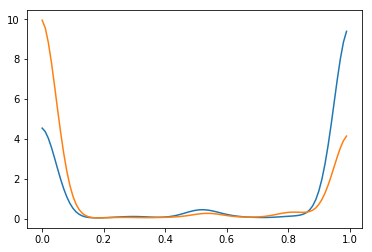

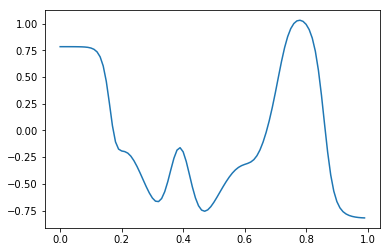

hbond
(1514,) (2260,)
11 (1514,)
28 (2260,)


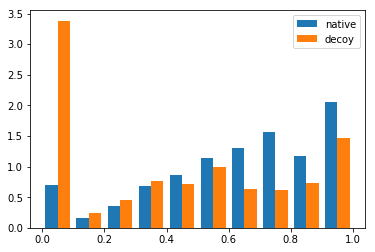

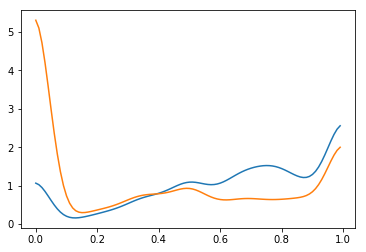

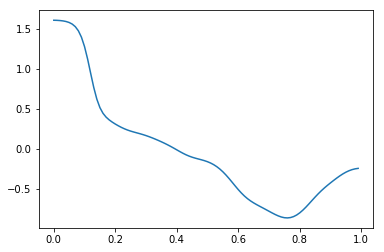

contact
(1514,) (2260,)
0 (1514,)
10 (2260,)


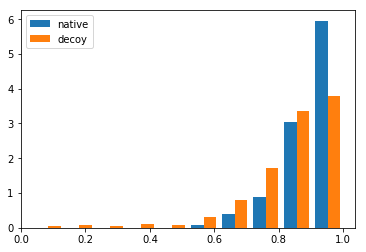

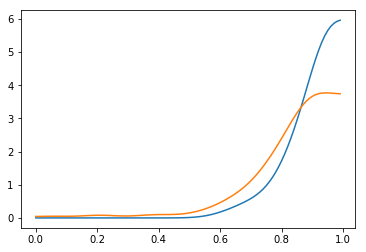

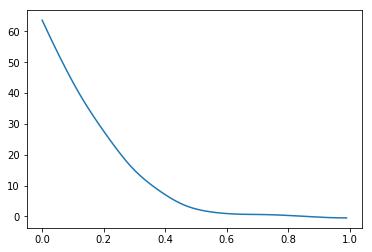

pipi
(1514,) (2260,)
385 (1514,)
252 (2260,)


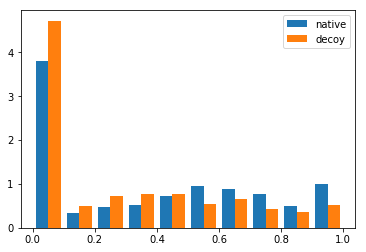

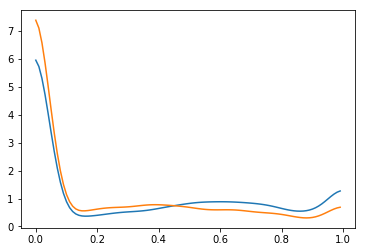

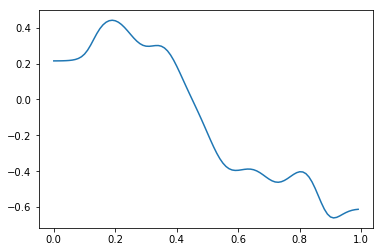

In [9]:
for interaction in ['sb2', 'hbond','contact', 'pipi']:
    native, decoy = [], []
    for protein, ligpairs in data.items():
        for (lig1, lig2), posepairs in ligpairs.items():
            for (rank1, rank2), fp in posepairs.items():
                if fp['mcss'] != float('inf'): continue
                if rank1 == rank2 == 0:
                    decoy += [fp[interaction]]
                if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                    native += [fp[interaction]]
                    break
    native, decoy = np.array(native), np.array(decoy)
    print interaction
    print native.shape, decoy.shape
    plot(native, decoy)

# Top Glide Incorrect v. First Correct

sb2
(1727,) (2431,)
1178 (1727,)
1805 (2431,)


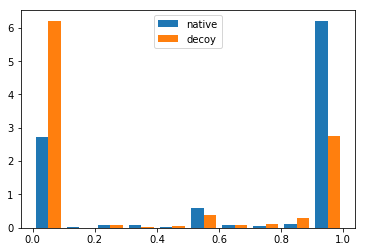

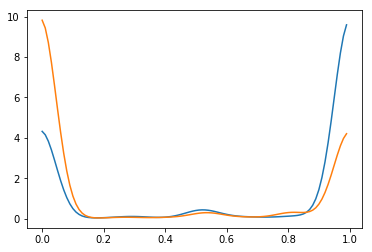

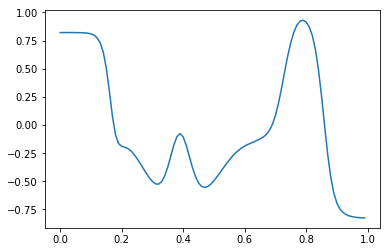

hbond
(1727,) (2431,)
11 (1727,)
29 (2431,)


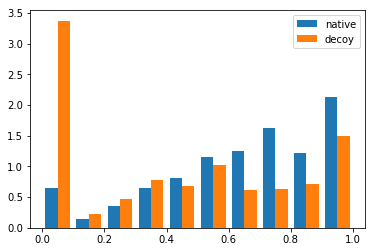

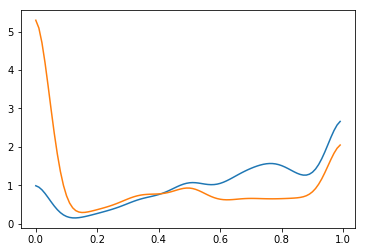

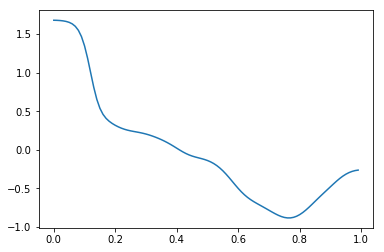

mcss
(1727,) (2431,)
1511 (1727,)
2257 (2431,)


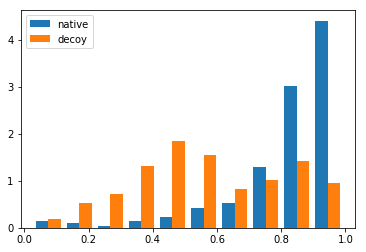

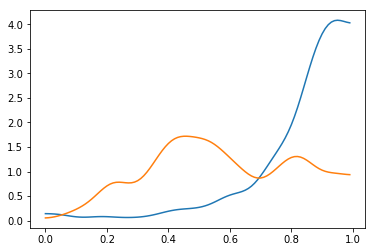

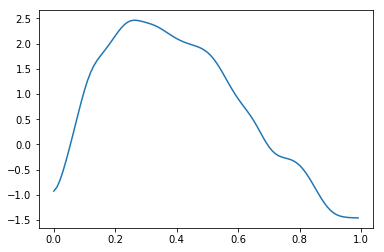

contact
(1727,) (2431,)
0 (1727,)
10 (2431,)


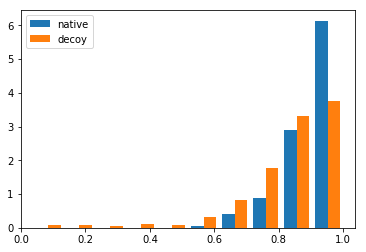

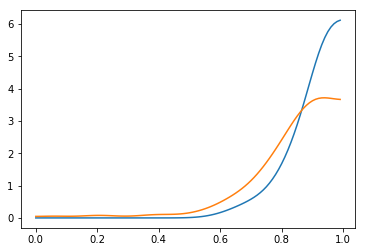

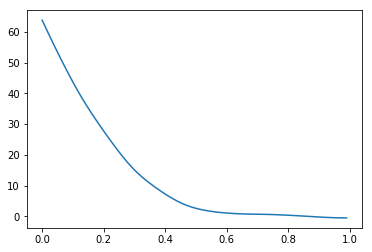

In [12]:
for interaction in ['sb2', 'hbond', 'mcss', 'contact']:
    native, decoy = [], []
    for protein, ligpairs in data.items():
        for (lig1, lig2), posepairs in ligpairs.items():
            for (rank1, rank2), fp in posepairs.items():
                if rank1 == rank2 == 0:
                    if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                        break
                    decoy += [fp[interaction]]
                if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                    native += [fp[interaction]]
                    break
    native, decoy = np.array(native), np.array(decoy)
    print interaction
    print native.shape, decoy.shape
    plot(native, decoy)

sb2
(1511,) (2257,)
1027 (1511,)
1682 (2257,)


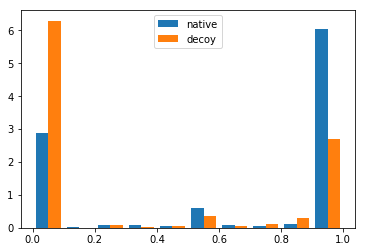

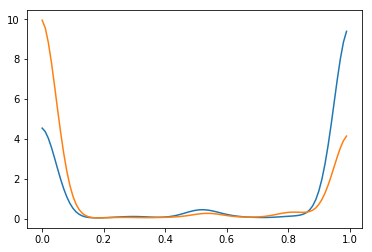

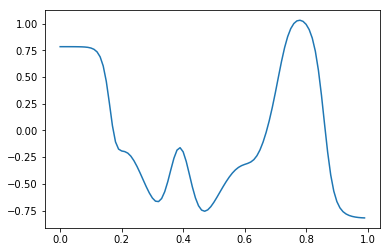

hbond
(1511,) (2257,)
11 (1511,)
28 (2257,)


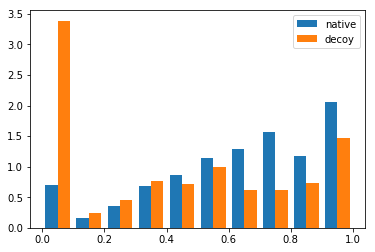

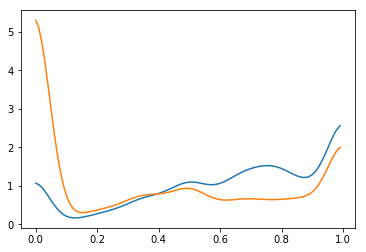

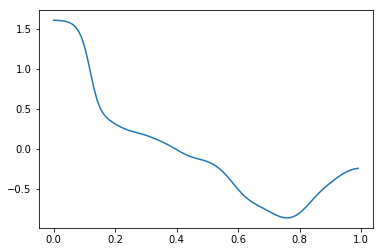

contact
(1511,) (2257,)
0 (1511,)
10 (2257,)


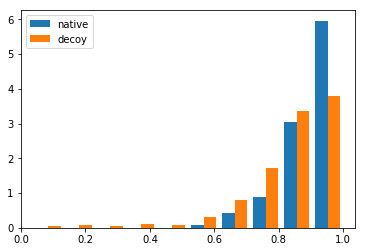

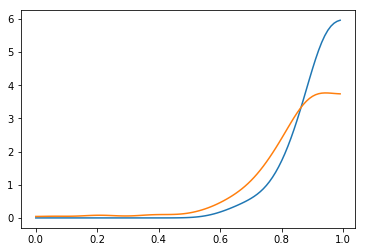

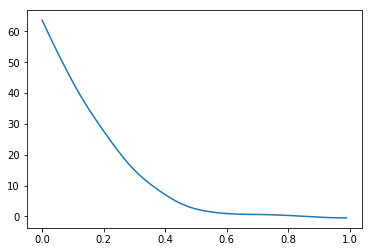

In [14]:
for interaction in ['sb2', 'hbond', 'contact']:
    native, decoy = [], []
    for protein, ligpairs in data.items():
        for (lig1, lig2), posepairs in ligpairs.items():
            for (rank1, rank2), fp in posepairs.items():
                if fp['mcss'] != float('inf'): continue
                if rank1 == rank2 == 0:
                    if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                        break
                    decoy += [fp[interaction]]
                if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                    native += [fp[interaction]]
                    break
    native, decoy = np.array(native), np.array(decoy)
    print interaction
    print native.shape, decoy.shape
    plot(native, decoy)

sb2
(216,) (174,)
151 (216,)
123 (174,)


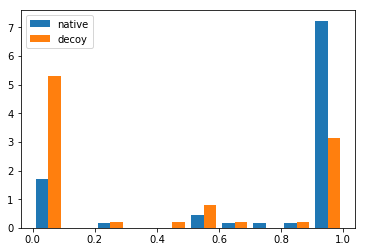

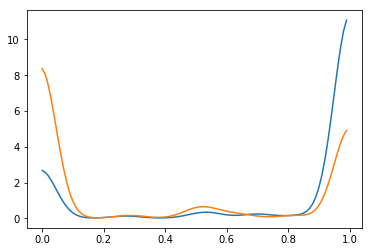

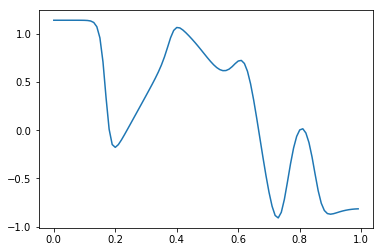

hbond
(216,) (174,)
0 (216,)
1 (174,)


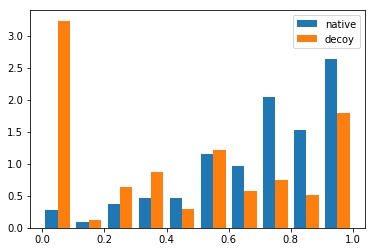

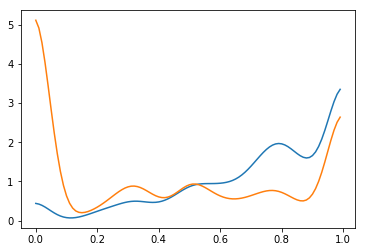

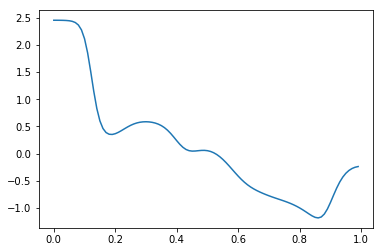

mcss
(216,) (174,)
0 (216,)
0 (174,)


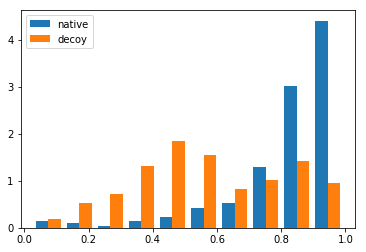

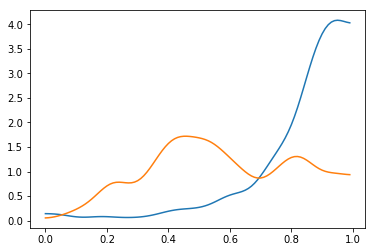

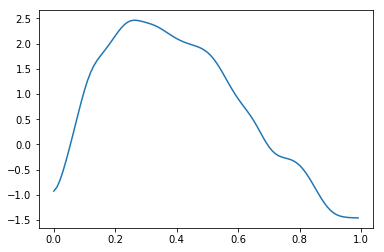

contact
(216,) (174,)
0 (216,)
0 (174,)


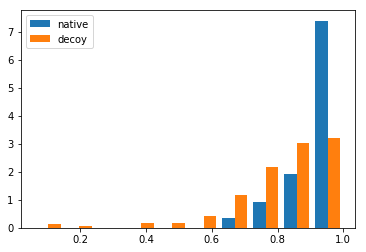

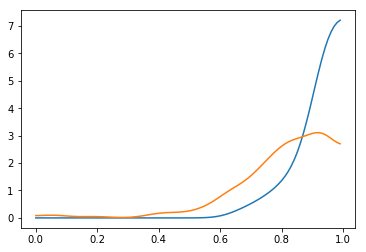

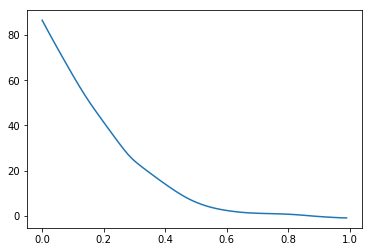

In [13]:
for interaction in ['sb2', 'hbond', 'mcss', 'contact']:
    native, decoy = [], []
    for protein, ligpairs in data.items():
        for (lig1, lig2), posepairs in ligpairs.items():
            for (rank1, rank2), fp in posepairs.items():
                if fp['mcss'] == float('inf'): continue
                if rank1 == rank2 == 0:
                    if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                        break
                    decoy += [fp[interaction]]
                if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2:
                    native += [fp[interaction]]
                    break
    native, decoy = np.array(native), np.array(decoy)
    print interaction
    print native.shape, decoy.shape
    plot(native, decoy)

# First correct versus most similar incorrect

sb2
(1205,) (1205,)
839 (1205,)
839 (1205,)


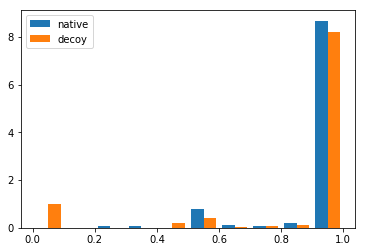

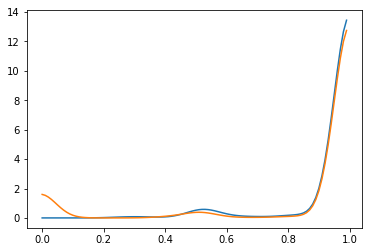

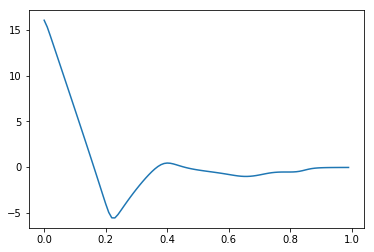

hbond
(1252,) (1252,)
3 (1252,)
3 (1252,)


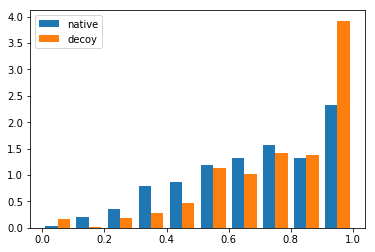

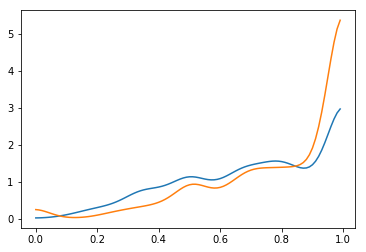

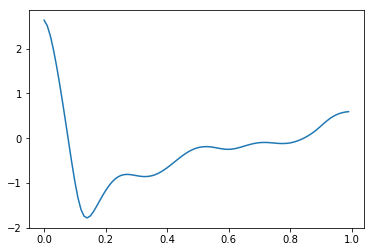

mcss
(1349,) (1349,)
1205 (1349,)
1205 (1349,)


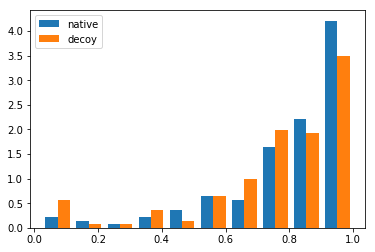

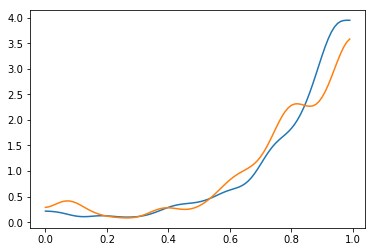

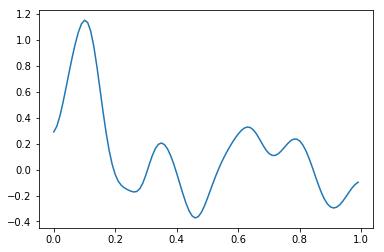

contact
(1349,) (1349,)
0 (1349,)
0 (1349,)


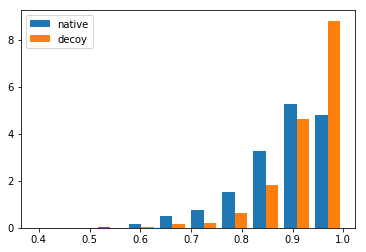

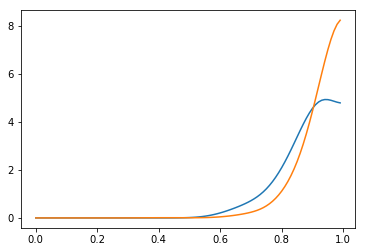

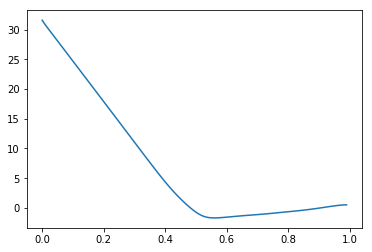

In [6]:
for interaction in ['sb2', 'hbond', 'mcss', 'contact']:
    native, decoy = [], []
    for protein, ligpairs in data.items():
        for (lig1, lig2), posepairs in ligpairs.items():
            _decoy = []
            _native = None
            for (rank1, rank2), fp in posepairs.items():
                if fp['rmsd1'] <= 2 and fp['rmsd2'] <= 2 and _native is None:
                    _native = fp[interaction]
                if sum([fp['rmsd1'] > 2, fp['rmsd2'] > 2]) == 1:
                    _decoy += [fp[interaction]]
            if _decoy and _native:
                native += [_native]
                decoy += [max(_decoy)]
    native, decoy = np.array(native), np.array(decoy)
    print interaction
    print native.shape, decoy.shape
    plot(native, decoy)